In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from multiprocessing import Pool
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool, cv
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import seaborn as sns

train_main = pd.read_parquet('data/train/train_main_df.parquet')
test_main = pd.read_parquet('data/test/test_main_df.parquet')
# train_mcc = pd.read_parquet('data/train/train_mcc_preferences_df.parquet')
# test_mcc = pd.read_parquet('data/test/test_mcc_preferences_df.parquet')
# train_spend = pd.read_parquet('data/train/train_card_spending_df.parquet')
# test_spend = pd.read_parquet('data/test/test_card_spending_df.parquet')
# train_ops = pd.read_parquet('data/train/train_mcc_operations_df.parquet')
# test_ops = pd.read_parquet('data/test/test_mcc_operations_df.parquet')
train = train_main
test = test_main
target = pd.read_csv('data/info/train_target.csv')

In [37]:
# features = [col for col in train.columns if col.endswith('3m') and 'MCC' in col]
features = [col for col in train.columns if train[col].dtype in ['int64', 'float64']]

In [38]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

In [40]:
model = xgb.XGBRegressor(objective='reg:squarederror',
    n_estimators=120,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_alpha=0.1,
    reg_lambda=1.0,
    tree_method='hist',
    n_jobs=-1)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(train[features], target['target'], test_size=0.3, random_state=42, shuffle=False)

In [42]:
# Базовое качество (все признаки)
methods = []
rmse_values = []
rmse_base = evaluate_model(model, X_train, X_test, y_train, y_test)
print(f"RF, Базовое RMSE (все признаки): {rmse_base:.4f}")
methods.append('RF, Базовое качество')
rmse_values.append(rmse_base)

RF, Базовое RMSE (все признаки): 737238.3548


In [43]:
pd.options.display.float_format = '{:,.3f}'.format
# Вычисляем дисперсию, уберем 3 самые большие, чтоб соблюсти масштаб
variances = X_train.var()

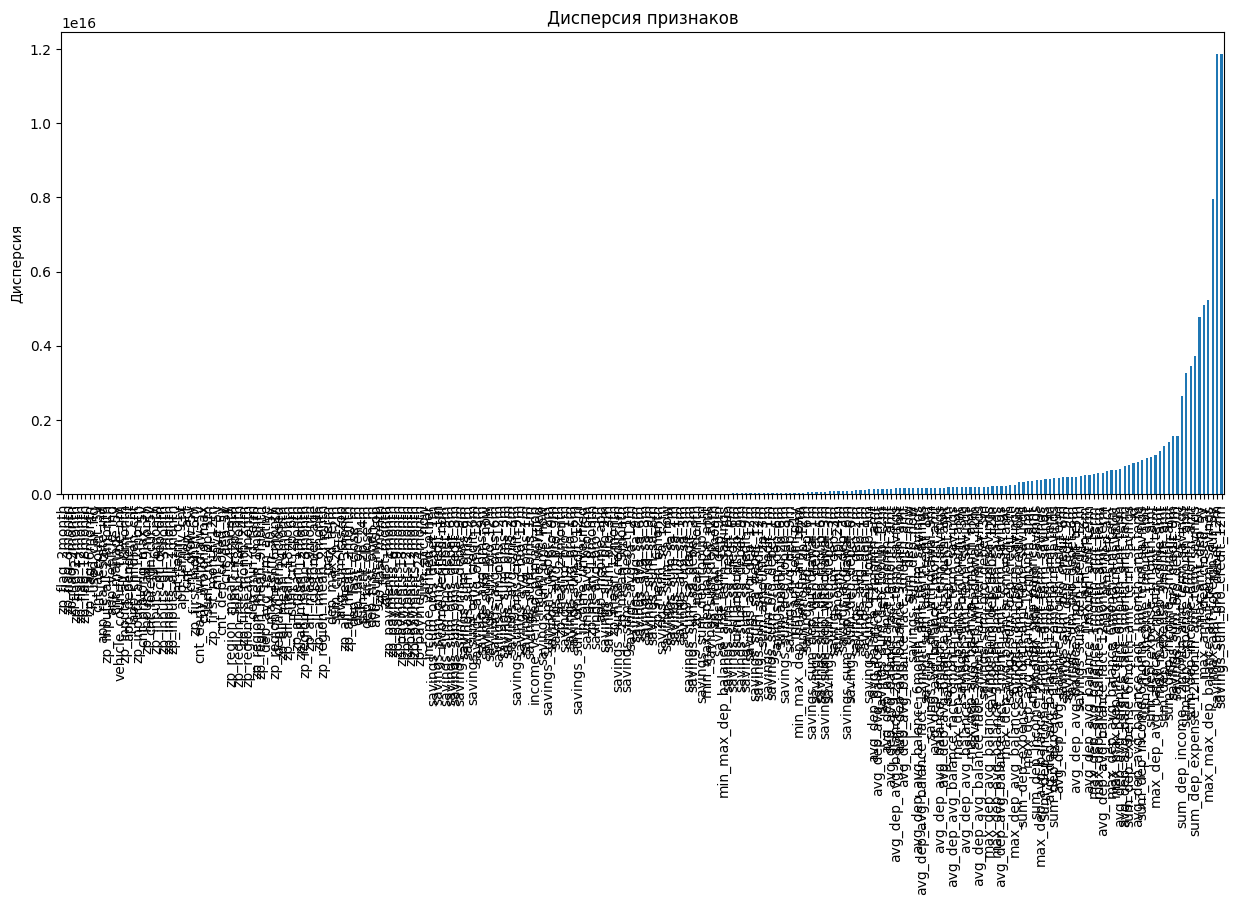

In [44]:
plt.figure(figsize=(15, 6))
variances.sort_values().iloc[:-3].plot(kind='bar')
plt.title('Дисперсия признаков')
plt.ylabel('Дисперсия')
plt.show()

In [45]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01)
selector.fit(X_train) 

,threshold,0.01


In [46]:
# Получаем маску и названия сохраненных признаков
selected_mask = selector.get_support()
selected_features = X_train.columns[selected_mask]
dropped_features = set(X_train.columns) - set(selected_features)

In [47]:
# Создаем новые DataFrame с сохраненной структурой
X_train_low_var = pd.DataFrame(
    selector.transform(X_train),
    columns=selected_features,
    index=X_train.index
)
X_test_low_var = pd.DataFrame(
    selector.transform(X_test),
    columns=selected_features,
    index=X_test.index
)

In [48]:
# Оценка качества
rmse_low_var = evaluate_model(model, X_train_low_var, X_test_low_var, y_train, y_test)
print(f"RMSE после удаления низковариативных признаков: {rmse_low_var:.4f}")
print(f"Удалено признаков: {len(dropped_features)}")
print(f"Удаленные признаки: {dropped_features}")

methods.append('RF, Низкая вариативность')
rmse_values.append(rmse_low_var)

RMSE после удаления низковариативных признаков: 720958.9143
Удалено признаков: 10
Удаленные признаки: {'zp_flag_18month', 'zp_flag_2month', 'cnt_account_5y', 'used_car_flg', 'zp_flag_24month', 'zp_flag_9month', 'zp_flag_12month', 'zp_flag_6month', 'app_real_estate_ind', 'zp_flag_3month'}


In [49]:
corr_matrix = X_train_low_var.corr().abs()

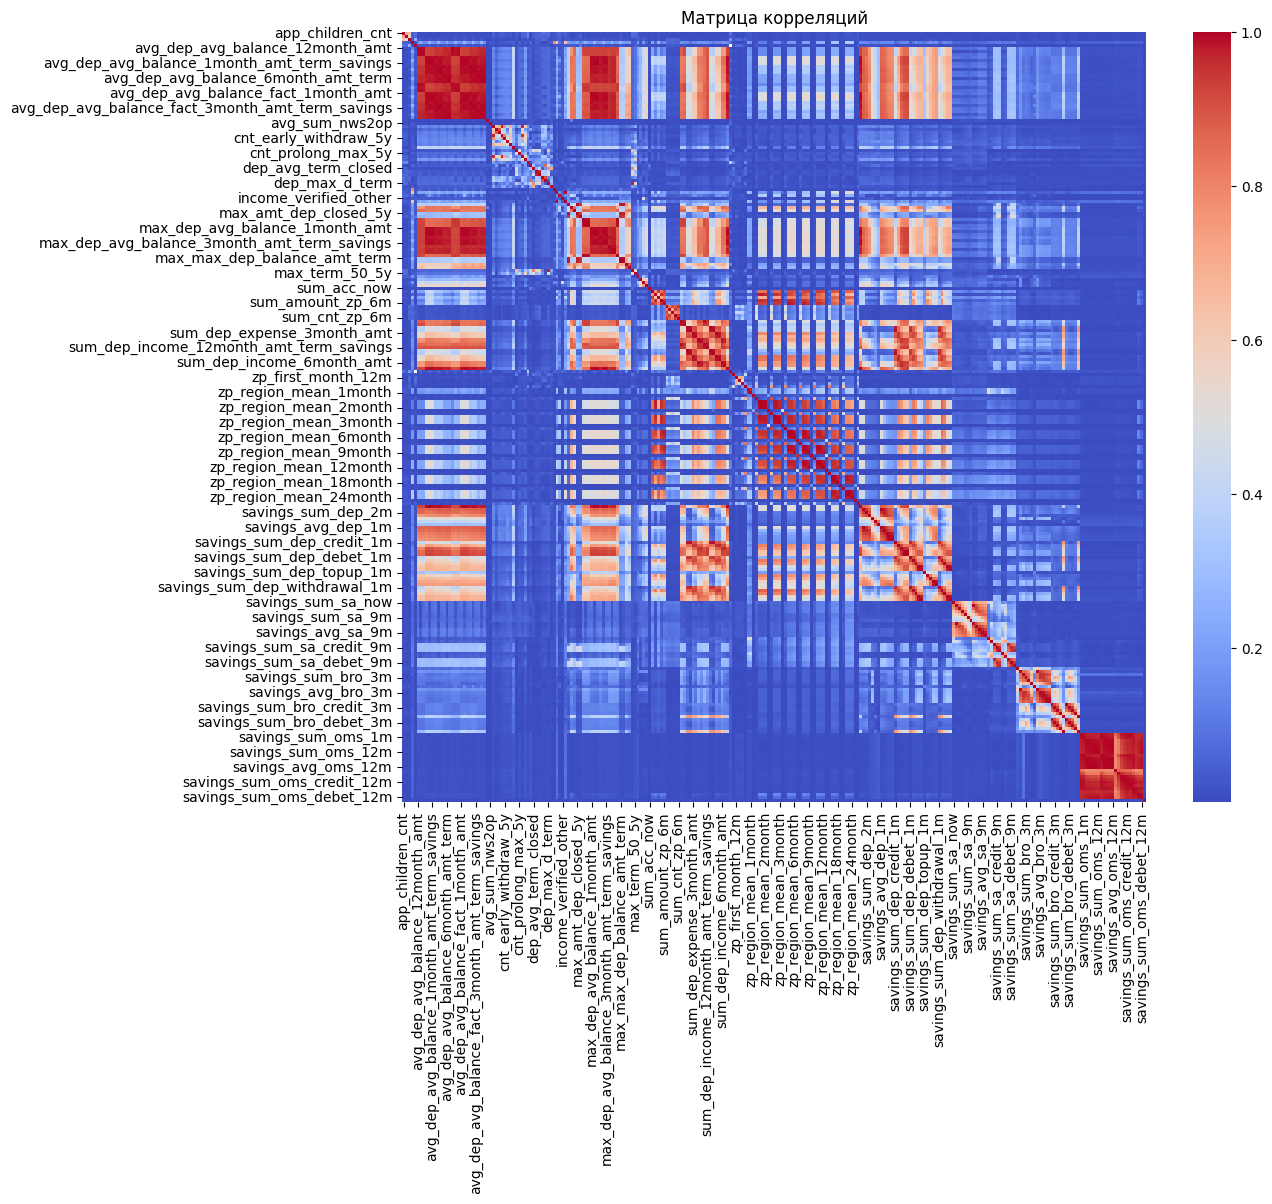

In [50]:
# Визуализация
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Матрица корреляций')
plt.show()

In [51]:
# Удаление высокоскоррелированных признаков (threshold > 0.95)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['avg_dep_avg_balance_12month_amt_term',
 'avg_dep_avg_balance_12month_amt_term_savings',
 'avg_dep_avg_balance_1month_amt_term',
 'avg_dep_avg_balance_1month_amt_term_savings',
 'avg_dep_avg_balance_3month_amt',
 'avg_dep_avg_balance_3month_amt_term',
 'avg_dep_avg_balance_3month_amt_term_savings',
 'avg_dep_avg_balance_6month_amt',
 'avg_dep_avg_balance_6month_amt_term',
 'avg_dep_avg_balance_6month_amt_term_savings',
 'avg_dep_avg_balance_fact_12month_amt',
 'avg_dep_avg_balance_fact_12month_amt_term',
 'avg_dep_avg_balance_fact_12month_amt_term_savings',
 'avg_dep_avg_balance_fact_1month_amt',
 'avg_dep_avg_balance_fact_1month_amt_term',
 'avg_dep_avg_balance_fact_1month_amt_term_savings',
 'avg_dep_avg_balance_fact_3month_amt',
 'avg_dep_avg_balance_fact_3month_amt_term',
 'avg_dep_avg_balance_fact_3month_amt_term_savings',
 'avg_dep_avg_balance_fact_6month_amt',
 'avg_dep_avg_balance_fact_6month_amt_term',
 'avg_dep_avg_balance_fact_6month_amt_term_savings',
 'cnt_dep_closed_5y',

In [52]:
X_train_uncorr = X_train_low_var.drop(columns=to_drop)
X_test_uncorr = X_test_low_var.drop(columns=to_drop)

rmse_uncorr = evaluate_model(model, X_train_uncorr, X_test_uncorr, y_train, y_test)
print(f"RMSE после удаления скоррелированных признаков: {rmse_uncorr:.4f}")
print(f"Удалено признаков: {len(to_drop)}")

methods.append('RF, Корреляция')
rmse_values.append(rmse_uncorr)

RMSE после удаления скоррелированных признаков: 773614.2924
Удалено признаков: 136


In [53]:
X_train_uncorr

,app_children_cnt,app_dependent_cnt,app_family_cnt,app_income_app,app_vehicle_ind,avg_dep_avg_balance_12month_amt,avg_dep_avg_balance_1month_amt,avg_sum_cls2op,avg_sum_nws2op,cnt_dep_5y,...,savings_sum_bro_12m,savings_sum_bro_credit_1m,savings_sum_bro_credit_3m,savings_sum_bro_credit_6m,savings_sum_bro_credit_9m,savings_sum_bro_credit_12m,savings_sum_oms_now,savings_sum_oms_credit_1m,savings_sum_oms_credit_3m,id
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,...,301.488,"18,902.783",0.000,"3,774.722","20,401.975",0.000,0.000,0.000,0.000,"97,678,374.000"
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,...,0.000,"3,404.037","40,335.562",0.000,0.000,0.000,0.000,12.183,9.087,"62,472,650.000"
2,0.000,0.000,0.000,"105,372.961",0.000,"315,208.781","235,661.922",NaN,NaN,0.000,...,0.000,"7,846.270",0.000,"31,165.807","31,318.211","6,749.115",0.000,12.083,32.913,"94,308,112.000"
3,1.000,0.000,3.000,0.000,0.000,"43,187.953","28,440.510",NaN,NaN,0.000,...,123.319,0.000,0.000,"49,764.176","50,802.379","18,114.295",84.427,0.000,38.087,"68,994,873.000"
4,NaN,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,0.000,...,0.000,"17,023.242","35,097.145",867.108,"32,588.312","20,955.273",0.000,8.280,0.000,"78,127,603.000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59907,0.000,0.000,2.000,NaN,0.000,NaN,NaN,NaN,NaN,0.000,...,111.686,"21,762.271",0.000,"18,642.865","9,814.733",0.000,0.000,0.000,0.000,"74,935,880.000"
59908,NaN,NaN,NaN,NaN,NaN,"895,963.750","1,146,630.250",0.997,1.041,3.000,...,"21,617.096",0.000,0.000,"30,484.498","598,076.625","623,046.688",65.286,6.480,0.000,"16,351,095.000"
59909,NaN,NaN,NaN,NaN,NaN,"7,119.484",0.000,NaN,NaN,0.000,...,0.000,"9,818.893","12,317.924","45,200.191","25,700.826",0.000,0.000,0.000,7.474,"75,901,675.000"
59910,NaN,NaN,NaN,NaN,0.000,796.040,0.000,0.924,NaN,0.000,...,287.175,0.000,"4,198.836",0.000,"50,474.277",0.000,0.000,0.000,0.000,"66,676,006.000"


In [54]:
from sklearn.feature_selection import f_regression, SelectKBest
X_train_uncorr = X_train_uncorr[X_train_uncorr.columns].fillna(0)
X_test_uncorr = X_test_uncorr[X_test_uncorr.columns].fillna(0)
y_train

0             0.000
1             0.000
2       219,932.906
3           631.770
4             0.000
            ...    
59907         0.000
59908   468,464.156
59909         0.000
59910         0.000
59911         0.000
Name: target, Length: 59912, dtype: float64

In [56]:
# проверяем стат. значимость связи
selector = SelectKBest(score_func=f_regression, k=10)
selector.fit(X_train_uncorr, y_train)

,score_func,<function f_r...001AA8B341B20>
,k,10


In [57]:
# Получаем выбранные признаки
selected_mask = selector.get_support()
selected_features = X_train_uncorr.columns[selected_mask]
dropped_features = set(X_train_uncorr.columns) - set(selected_features)

In [58]:
print("\n2. SelectKBest результаты:")
print(f"Выбрано признаков: {len(selected_features)}")
print(f"Выбранные признаки: {list(selected_features)}")
print(f"Удалённые признаки: {len(dropped_features)}")


2. SelectKBest результаты:
Выбрано признаков: 10
Выбранные признаки: ['savings_sum_sa_now', 'savings_sum_sa_1m', 'savings_sum_sa_2m', 'savings_sum_sa_3m', 'savings_sum_sa_6m', 'savings_sum_sa_9m', 'savings_sum_sa_12m', 'savings_avg_sa_3m', 'savings_avg_sa_6m', 'savings_sum_sa_credit_3m']
Удалённые признаки: 111


In [59]:
f_scores = pd.Series(selector.scores_, index=X_train_uncorr.columns)
p_values = pd.Series(selector.pvalues_, index=X_train_uncorr.columns)

In [60]:
print("\nТоп-5 признаков по F-статистике:")
print(f_scores.sort_values(ascending=False).head(10))

print("\nПризнаки с наименьшими p-values:")
print(p_values.sort_values().head(5))
f_scores


Топ-5 признаков по F-статистике:
savings_sum_sa_now         215,916.316
savings_sum_sa_1m          162,778.907
savings_sum_sa_2m           91,712.516
savings_avg_sa_3m           88,674.250
savings_avg_sa_6m           61,436.614
savings_sum_sa_3m           42,767.407
savings_sum_sa_6m           28,731.989
savings_sum_sa_9m           16,180.295
savings_sum_sa_12m          11,419.791
savings_sum_sa_credit_3m     7,333.664
dtype: float64

Признаки с наименьшими p-values:
savings_sum_sa_12m         0.000
savings_avg_sa_3m          0.000
savings_sum_sa_2m          0.000
savings_sum_sa_3m          0.000
savings_sum_sa_credit_9m   0.000
dtype: float64


app_children_cnt              1.893
app_dependent_cnt             1.332
app_family_cnt                0.023
app_income_app               44.419
app_vehicle_ind              16.023
                              ...  
savings_sum_bro_credit_12m    0.074
savings_sum_oms_now           4.575
savings_sum_oms_credit_1m     0.568
savings_sum_oms_credit_3m     4.166
id                            0.348
Length: 121, dtype: float64

In [61]:
X_train_kbest = selector.transform(X_train_uncorr)
X_test_kbest = selector.transform(X_test_uncorr)

In [62]:
# Для интерпретации преобразуем в DataFrame
X_train_selected = pd.DataFrame(X_train_kbest, columns=selected_features, index=X_train.index)
X_test_selected = pd.DataFrame(X_test_kbest, columns=selected_features, index=X_test.index)

In [63]:
rmse_uncorr = evaluate_model(model, X_train_selected, X_test_selected, y_train, y_test)
print(f"RMSE после отбора признаков: {rmse_uncorr:.4f}")

methods.append('RF, F-тест')
rmse_values.append(rmse_uncorr)

RMSE после отбора признаков: 781818.7429


In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# Масштабируем данные для корректного сравнения весов
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_uncorr)
X_test_scaled = scaler.transform(X_test_uncorr)

# Обучаем линейную регрессию
lr = LinearRegression(fit_intercept=True)
lr.fit(X_train_scaled, y_train)

# Получаем веса
weights = pd.Series(lr.coef_, index=X_train_uncorr.columns)
weights

app_children_cnt               -4,033.685
app_dependent_cnt              -1,489.360
app_family_cnt                    698.413
app_income_app               -222,954.803
app_vehicle_ind                 1,490.885
                                 ...     
savings_sum_bro_credit_12m     -8,616.321
savings_sum_oms_now              -292.022
savings_sum_oms_credit_1m      -7,225.375
savings_sum_oms_credit_3m       7,276.421
id                               -963.193
Length: 121, dtype: float64

In [66]:
positive_features = weights[weights > 0]
print("Признаки с положительными весами:")
print("[" + ", ".join(f"'{feat}'" for feat in positive_features.index.tolist()) + "]")

# Для удобства копирования выводим также просто списком
print("\nСписок для копирования:")
for feat in positive_features.index:
    print(f"'{feat}'")

Признаки с положительными весами:
['app_family_cnt', 'app_vehicle_ind', 'avg_dep_avg_balance_1month_amt', 'avg_sum_nws2op', 'cnt_dep_5y', 'cnt_dep_act', 'cnt_foreign_cur_5y', 'cnt_grow_5y', 'cnt_prolong_max', 'cnt_term_g1y', 'customer_age', 'dep_avg_term_active', 'dep_avg_term_closed', 'dep_first_close_m', 'dep_last_open_m', 'income_unverified', 'income_verified', 'income_verified_ndfl', 'max_amt_dep_5y', 'max_dep_avg_balance_12month_amt', 'max_max_dep_income_amt_term_savings', 'min_amt_term_g1y', 'min_max_dep_balance_amt', 'min_max_dep_balance_amt_term', 'min_max_dep_balance_amt_term_savings', 'sum_acc_now', 'sum_amount_zp_12m', 'sum_cnt_zp_12m', 'sum_cnt_zp_3m', 'sum_dep_expense_6month_amt', 'zp_first_month', 'zp_first_month_12m', 'zp_first_month_6m', 'zp_last_month', 'zp_all_mean_1month', 'zp_payments_2month', 'zp_inputs_all_2month', 'zp_inputs_all_6month', 'zp_inputs_all_9month', 'zp_payments_12month', 'zp_inputs_all_18month', 'zp_payments_24month', 'savings_sum_dep_6m', 'savings_s

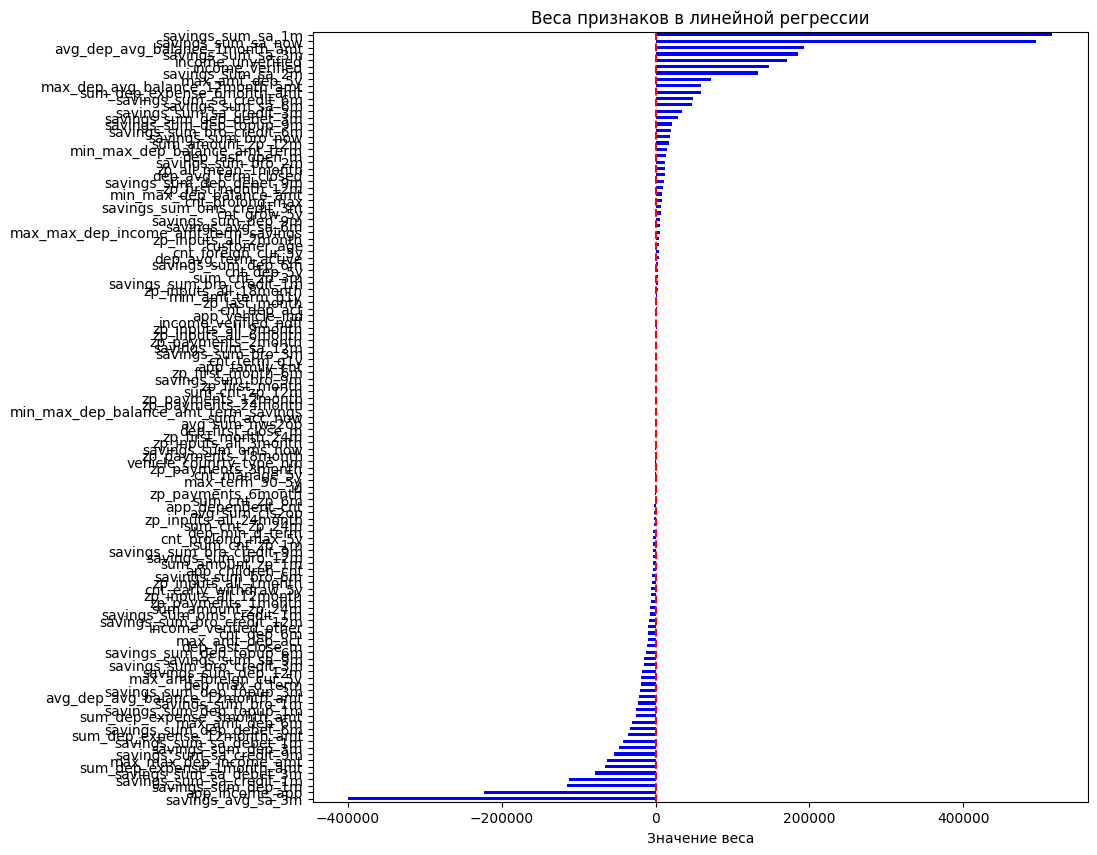

In [67]:
# Визуализация весов
plt.figure(figsize=(10, 10))
weights.sort_values().plot(kind='barh', color='blue')
plt.title('Веса признаков в линейной регрессии')
plt.xlabel('Значение веса')
plt.axvline(x=0, color='r', linestyle='--')
plt.show()

In [69]:
# Качество модели
y_pred_lr = lr.predict(X_test_scaled)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"\nRMSE линейной регрессии (все признаки): {rmse_lr:.4f}")


RMSE линейной регрессии (все признаки): 437573.7972


In [70]:
methods.append('LR')
rmse_values.append(rmse_lr)

In [73]:
# Выбираем 5 признаков с наибольшим абсолютным весом
top_features = weights.abs().sort_values(ascending=False).head(5).index
print(f"\nТоп признаков по важности (абсолютные веса): {list(top_features)}")


Топ признаков по важности (абсолютные веса): ['savings_sum_sa_1m', 'savings_sum_sa_now', 'savings_avg_sa_3m', 'app_income_app', 'avg_dep_avg_balance_1month_amt']


In [74]:
# Обучаем модель только на этих признаках
X_train_top = X_train_scaled[:, [weights.index.get_loc(f) for f in top_features]]
X_test_top = X_test_scaled[:, [weights.index.get_loc(f) for f in top_features]]

lr_top5 = LinearRegression()
lr_top5.fit(X_train_top, y_train)
y_pred_top5 = lr_top5.predict(X_test_top)
rmse_top5 = np.sqrt(mean_squared_error(y_test, y_pred_top5))
print(f"RMSE на топ признаках: {rmse_top5:.4f}")

RMSE на топ признаках: 434418.7938


In [75]:
methods.append('LR, top')
rmse_values.append(rmse_top5)

In [76]:
from sklearn.linear_model import LassoCV

In [79]:
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_train_scaled, y_train)

lasso_coef = pd.Series(lasso.coef_, index=X_train_uncorr.columns)

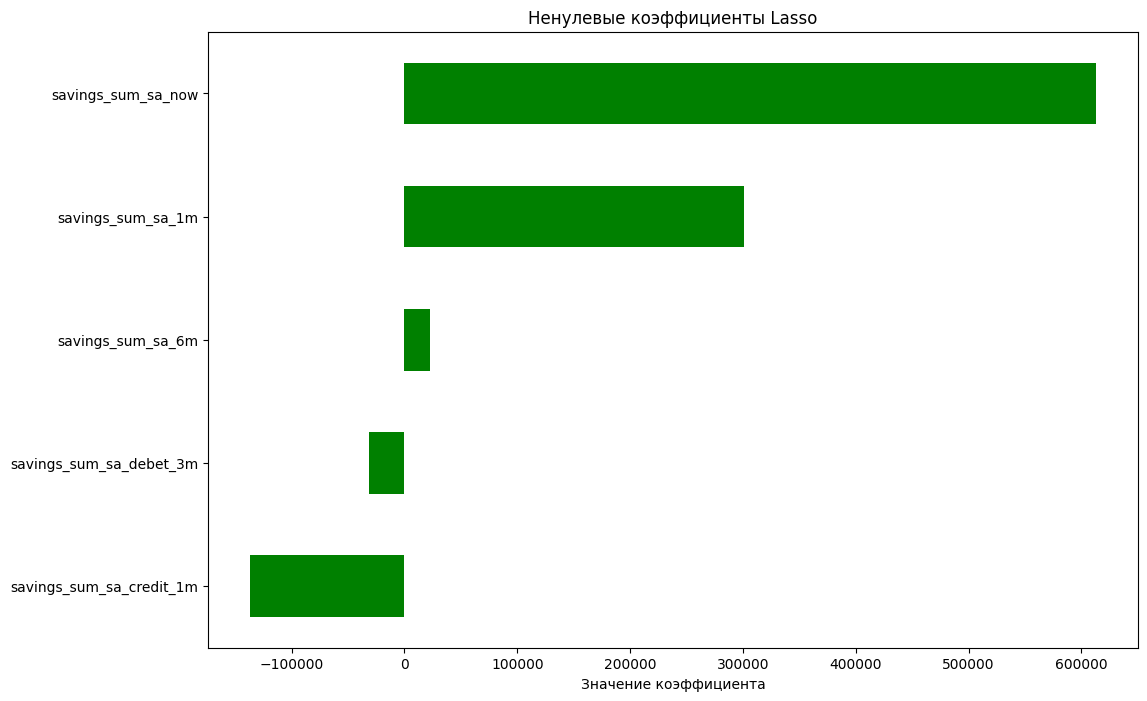

In [80]:
# Визуализация
plt.figure(figsize=(12, 8))
lasso_coef[lasso_coef != 0].sort_values().plot(kind='barh', color='green')
plt.title('Ненулевые коэффициенты Lasso')
plt.xlabel('Значение коэффициента')
plt.show()

In [81]:
selected_lasso = lasso_coef[lasso_coef != 0].index
print(f"\nLasso выбрал {len(selected_lasso)} признаков: {list(selected_lasso)}")


Lasso выбрал 5 признаков: ['savings_sum_sa_now', 'savings_sum_sa_1m', 'savings_sum_sa_6m', 'savings_sum_sa_credit_1m', 'savings_sum_sa_debet_3m']


In [83]:
# Качество модели
y_pred_lasso = lasso.predict(X_test_scaled)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
print(f"RMSE Lasso: {rmse_lasso:.4f}")
print(f"Улучшение по сравнению с полной моделью: {rmse_lr - rmse_lasso:.4f}")

RMSE Lasso: 353835.7266
Улучшение по сравнению с полной моделью: 83738.0706


In [84]:
methods.append('Lasso')
rmse_values.append(rmse_lasso)

In [87]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=10, max_depth=15, min_samples_split= 50)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,15
,min_samples_split,50
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [88]:
# Визуализация важности
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances = importances.sort_values(ascending=False)

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_4932\370239315.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


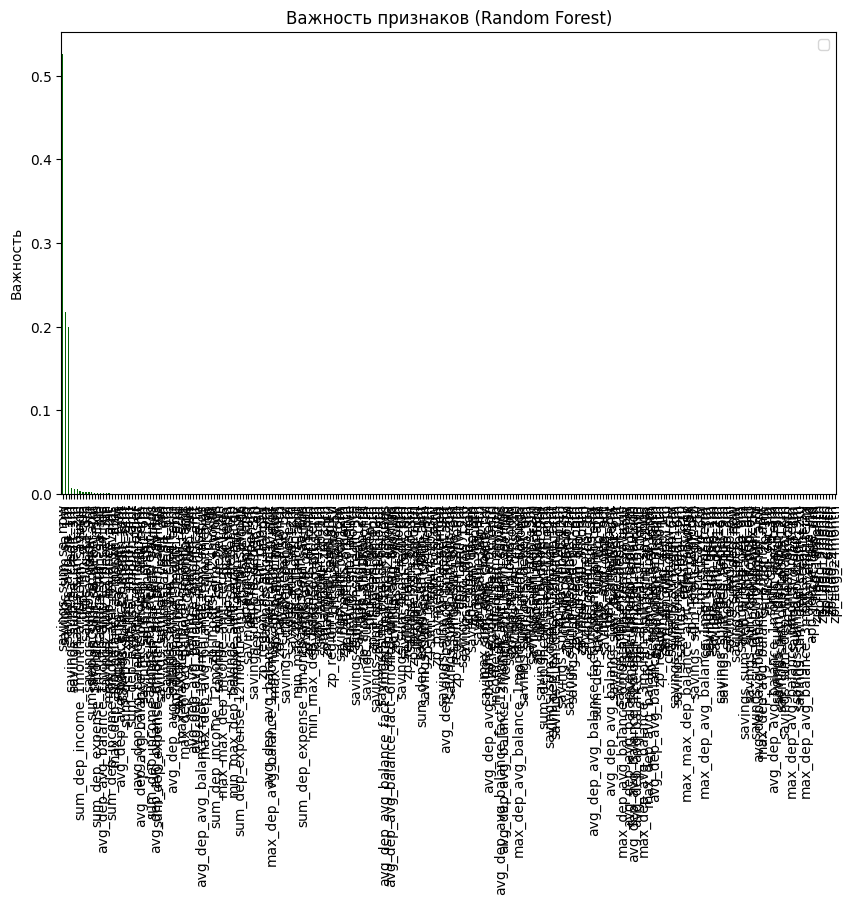

In [89]:
plt.figure(figsize=(10, 6))
importances.plot(kind='bar', color='darkgreen')
plt.title('Важность признаков (Random Forest)')
plt.ylabel('Важность')
# plt.axhline(y=0.01, color='r', linestyle='--', label='Порог важности (0.01)')
plt.legend()
plt.show()

In [90]:
importances[importances>0.001]

savings_sum_sa_now                        0.526
savings_sum_sa_1m                         0.217
savings_avg_sa_1m                         0.199
savings_sum_sa_credit_1m                  0.007
savings_sum_sa_credit_3m                  0.006
savings_sum_sa_2m                         0.005
sum_dep_income_1month_amt_term_savings    0.004
dep_min_d_term                            0.003
savings_avg_sa_3m                         0.003
savings_sum_sa_credit_9m                  0.003
sum_dep_income_1month_amt                 0.002
savings_sum_sa_debet_1m                   0.001
sum_dep_expense_1month_amt_term_savings   0.001
dtype: float64

In [91]:
# Удаляем неинформативные признаки
to_keep = importances[importances > 0.001].index
X_train_imp = X_train[to_keep]
X_test_imp = X_test[to_keep]

rmse_imp = evaluate_model(model, X_train_imp, X_test_imp, y_train, y_test)
print(f"4. RMSE после отбора по важности: {rmse_imp:.4f}")

4. RMSE после отбора по важности: 718358.4302


In [92]:
X_train_imp.columns

Index(['savings_sum_sa_now', 'savings_sum_sa_1m', 'savings_avg_sa_1m',
       'savings_sum_sa_credit_1m', 'savings_sum_sa_credit_3m',
       'savings_sum_sa_2m', 'sum_dep_income_1month_amt_term_savings',
       'dep_min_d_term', 'savings_avg_sa_3m', 'savings_sum_sa_credit_9m',
       'sum_dep_income_1month_amt', 'savings_sum_sa_debet_1m',
       'sum_dep_expense_1month_amt_term_savings'],
      dtype='object')

In [93]:
from catboost import CatBoostRegressor

In [94]:
cb = CatBoostRegressor(random_state=42)
cb.fit(X_train_uncorr, y_train)

Learning rate set to 0.078168
0:	learn: 885180.7579875	total: 152ms	remaining: 2m 31s
1:	learn: 838594.7320491	total: 170ms	remaining: 1m 24s
2:	learn: 794803.8160617	total: 183ms	remaining: 1m
3:	learn: 756826.5590265	total: 192ms	remaining: 47.9s
4:	learn: 720966.3221570	total: 205ms	remaining: 40.8s
5:	learn: 687339.0285651	total: 220ms	remaining: 36.5s
6:	learn: 655372.0661153	total: 234ms	remaining: 33.2s
7:	learn: 626722.9484060	total: 246ms	remaining: 30.5s
8:	learn: 600095.2500797	total: 255ms	remaining: 28.1s
9:	learn: 574245.0542601	total: 265ms	remaining: 26.2s
10:	learn: 551585.6981296	total: 273ms	remaining: 24.6s
11:	learn: 532222.6379864	total: 282ms	remaining: 23.3s
12:	learn: 512737.2881414	total: 291ms	remaining: 22.1s
13:	learn: 495216.6831132	total: 300ms	remaining: 21.1s
14:	learn: 479007.6526913	total: 309ms	remaining: 20.3s
15:	learn: 462853.5416931	total: 318ms	remaining: 19.5s
16:	learn: 449371.9059851	total: 326ms	remaining: 18.9s
17:	learn: 437520.3935132	tot

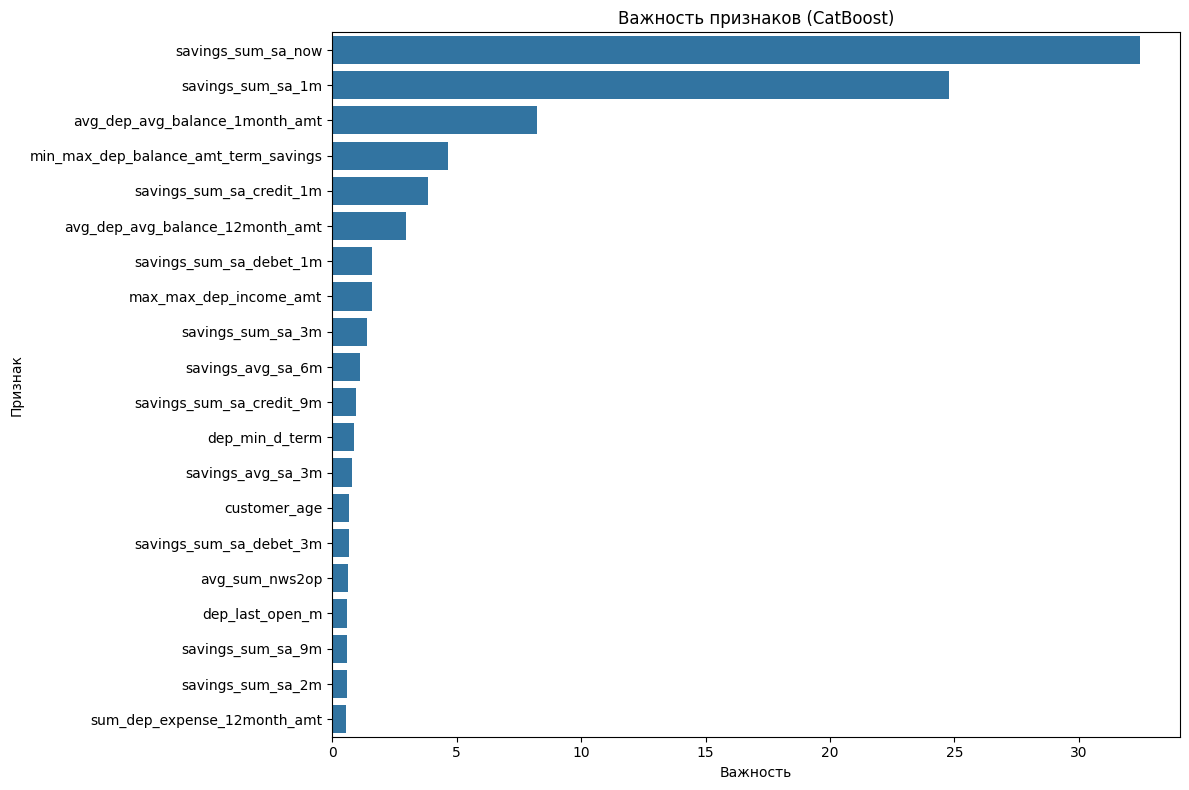

In [96]:
# Получение важности признаков
feature_importances = cb.get_feature_importance()
feature_names = X_train_uncorr.columns

# Создание DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# Визуализация
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Важность признаков (CatBoost)')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

In [97]:
from sklearn.feature_selection import RFECV

In [99]:
# Используем RFECV для автоматического выбора оптимального числа признаков
rfecv = RFECV(
    estimator=LinearRegression(),
    step=1,
    cv=5,
    scoring='neg_mean_squared_error',
    min_features_to_select=5
)
rfecv.fit(X_train_scaled, y_train)

,estimator,LinearRegression()
,step,1
,min_features_to_select,5
,cv,5
,scoring,'neg_mean_squared_error'
,verbose,0
,n_jobs,None
,importance_getter,'auto'
,fit_intercept,True
,copy_X,True
,tol,1e-06


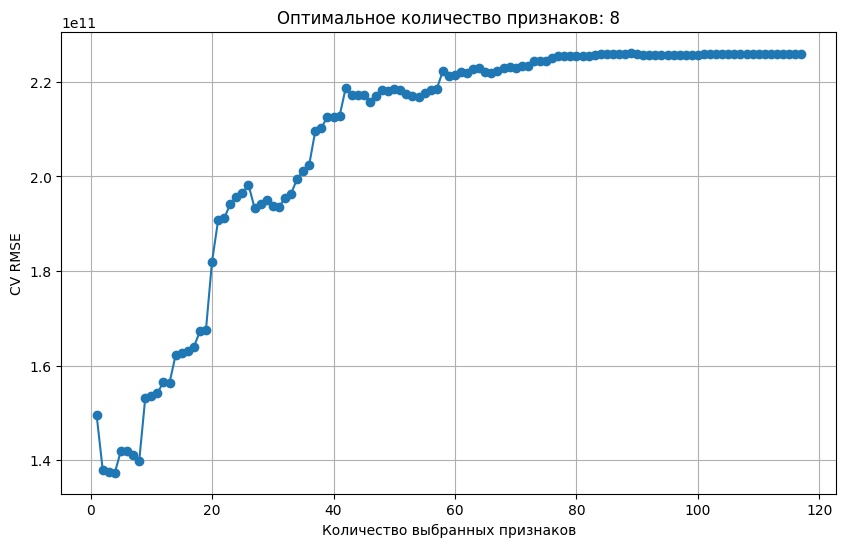

In [102]:
# Визуализация процесса отбора
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
         -rfecv.cv_results_['mean_test_score'], 'o-')
plt.xlabel("Количество выбранных признаков")
plt.ylabel("CV RMSE")
plt.title("Оптимальное количество признаков: {}".format(rfecv.n_features_))
plt.grid(True)
plt.show()

In [103]:
print("Оптимальное количество признаков:", rfecv.n_features_)
selected_rfecv = X_train_uncorr.columns[rfecv.support_]
print("Отобранные признаки:", list(selected_rfecv))

Оптимальное количество признаков: 8
Отобранные признаки: ['app_income_app', 'income_unverified', 'savings_sum_sa_now', 'savings_sum_sa_1m', 'savings_sum_sa_2m', 'savings_sum_sa_3m', 'savings_avg_sa_3m', 'savings_sum_sa_credit_1m']


In [105]:
# Качество на тесте
X_test_rfecv = rfecv.transform(X_test_scaled)
y_pred_rfecv = rfecv.estimator_.predict(X_test_rfecv)
rmse_rfecv = np.sqrt(mean_squared_error(y_test, y_pred_rfecv))
print(f"RMSE RFECV: {rmse_rfecv:.4f}")

RMSE RFECV: 335053.2670


In [106]:
methods.append('LR, RFECV')
rmse_values.append(rmse_rfecv)

In [107]:
from boruta import BorutaPy

In [108]:
# Инициализация Boruta
boruta = BorutaPy(
    estimator=model, # Любую модель c методам .fit(X, y) и .feature_importances_ или .coef_
    n_estimators='auto',
    max_iter=50,  
    verbose=1,    
    random_state=42
)

In [110]:
X_np = X_train_uncorr.values
y_np = y_train

In [111]:
boruta.fit(X_np, y_np)

Iteration: 1 / 50
Iteration: 2 / 50
Iteration: 3 / 50
Iteration: 4 / 50
Iteration: 5 / 50
Iteration: 6 / 50
Iteration: 7 / 50
Iteration: 8 / 50
Iteration: 9 / 50
Iteration: 10 / 50
Iteration: 11 / 50
Iteration: 12 / 50
Iteration: 13 / 50
Iteration: 14 / 50
Iteration: 15 / 50
Iteration: 16 / 50
Iteration: 17 / 50
Iteration: 18 / 50
Iteration: 19 / 50
Iteration: 20 / 50
Iteration: 21 / 50
Iteration: 22 / 50
Iteration: 23 / 50
Iteration: 24 / 50
Iteration: 25 / 50
Iteration: 26 / 50
Iteration: 27 / 50
Iteration: 28 / 50
Iteration: 29 / 50
Iteration: 30 / 50
Iteration: 31 / 50
Iteration: 32 / 50
Iteration: 33 / 50
Iteration: 34 / 50
Iteration: 35 / 50
Iteration: 36 / 50
Iteration: 37 / 50
Iteration: 38 / 50
Iteration: 39 / 50
Iteration: 40 / 50
Iteration: 41 / 50
Iteration: 42 / 50
Iteration: 43 / 50
Iteration: 44 / 50
Iteration: 45 / 50
Iteration: 46 / 50
Iteration: 47 / 50
Iteration: 48 / 50
Iteration: 49 / 50


BorutaPy finished running.

Iteration: 	50 / 50
Confirmed: 	4
Tentative: 	6


,estimator,"XGBRegressor(...ree=None, ...)"
,n_estimators,'auto'
,perc,100
,alpha,0.05
,two_step,True
,max_iter,50
,random_state,RandomState(M... 0x1AA8B9D3C40
,verbose,1
,early_stopping,False
,n_iter_no_change,20
,objective,'reg:squarederror'


In [112]:
selected_mask = boruta.support_
ranking = boruta.ranking_
selected_features = X_train_uncorr.columns[selected_mask].tolist()

In [113]:
boruta_df = pd.DataFrame({
        'Feature': X_train_uncorr.columns,
        'Ranking': ranking,
        'Selected': selected_mask
    }).sort_values('Ranking')
boruta_df

,Feature,Ranking,Selected
6,avg_dep_avg_balance_1month_amt,1,True
42,min_max_dep_balance_amt_term_savings,1,True
90,savings_sum_sa_now,1,True
91,savings_sum_sa_1m,1,True
32,max_amt_dep_6m,2,False
...,...,...,...
73,zp_inputs_all_12month,109,False
94,savings_sum_sa_6m,109,False
0,app_children_cnt,111,False
83,savings_sum_dep_debet_3m,112,False


In [114]:
boruta_df.head(20)

,Feature,Ranking,Selected
6,avg_dep_avg_balance_1month_amt,1,True
42,min_max_dep_balance_amt_term_savings,1,True
90,savings_sum_sa_now,1,True
91,savings_sum_sa_1m,1,True
32,max_amt_dep_6m,2,False
36,max_max_dep_income_amt,2,False
20,dep_avg_term_active,2,False
8,avg_sum_nws2op,2,False
19,customer_age,2,False
112,savings_sum_bro_credit_1m,2,False


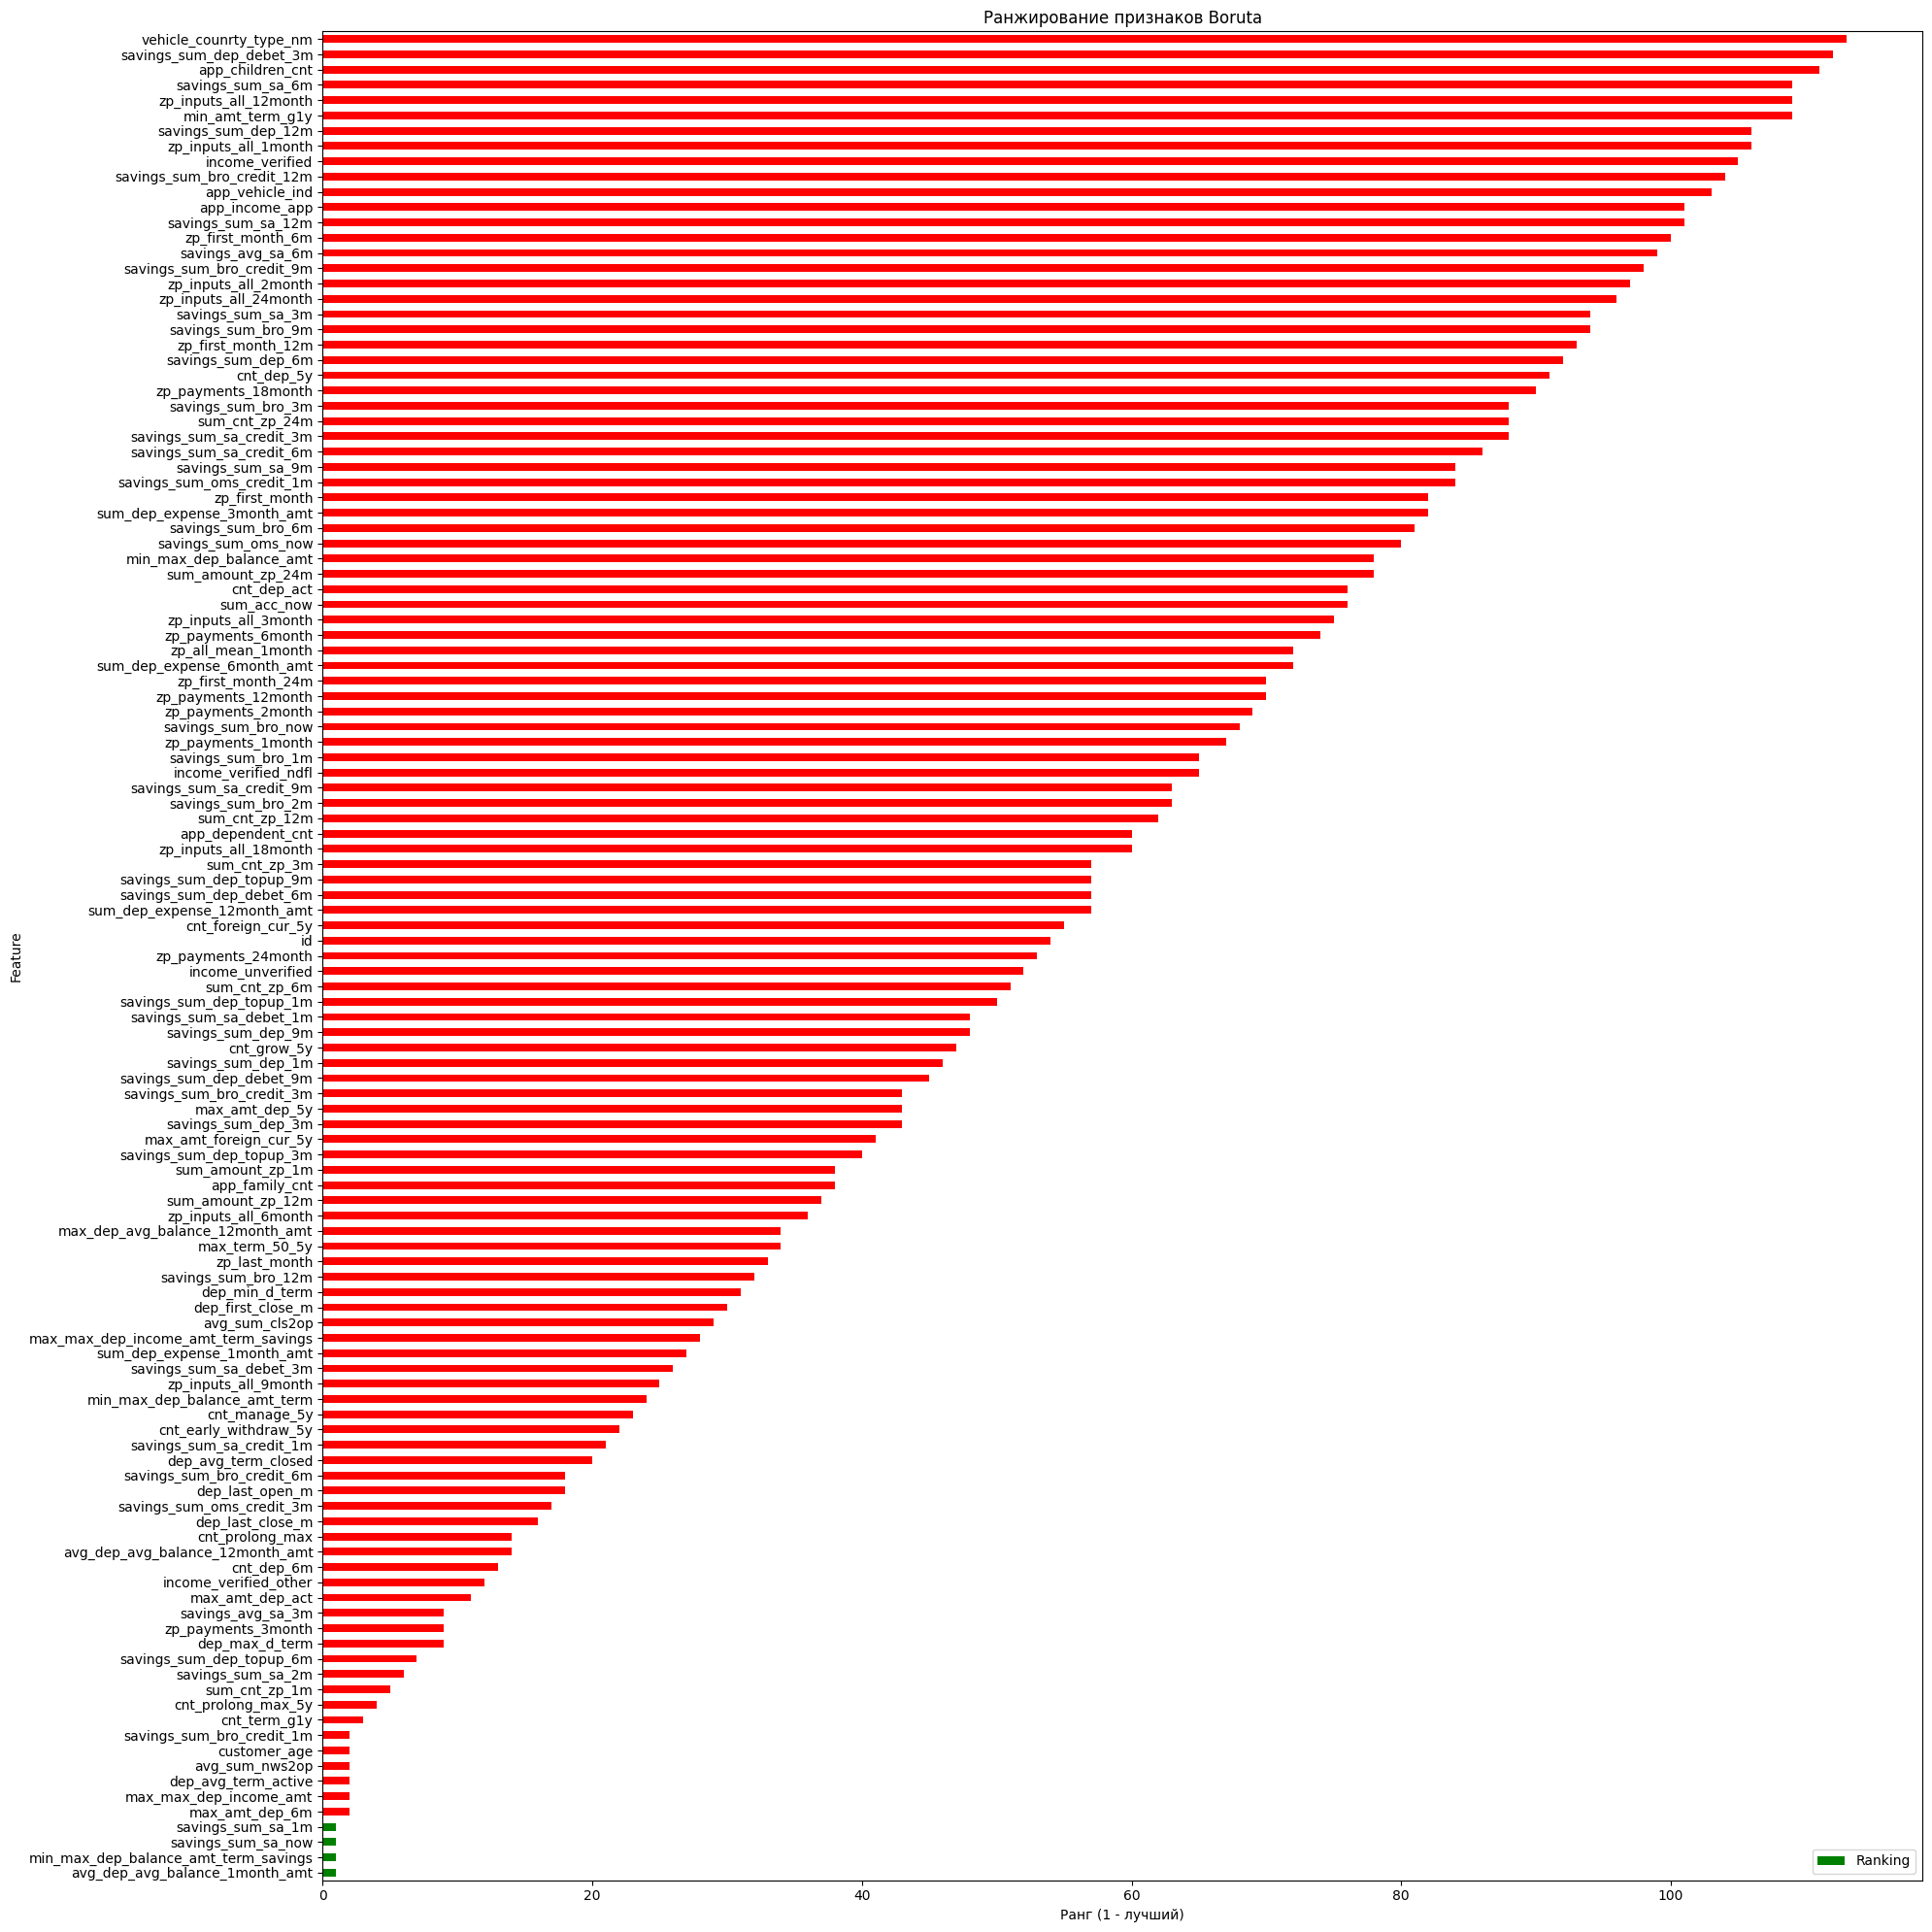

In [115]:
boruta_df.sort_values('Ranking').plot(
    kind='barh', 
    x='Feature', 
    y='Ranking', 
    legend=False,
    color=boruta_df['Selected'].map({True: 'green', False: 'red'}),
    figsize=(20, 20)
)
plt.title('Ранжирование признаков Boruta')
plt.xlabel('Ранг (1 - лучший)')
plt.legend()
plt.tight_layout()
plt.show()

In [116]:
print(f"Boruta выбрал признаки: {selected_features}")

Boruta выбрал признаки: ['avg_dep_avg_balance_1month_amt', 'min_max_dep_balance_amt_term_savings', 'savings_sum_sa_now', 'savings_sum_sa_1m']


In [117]:
X_train_boruta = X_train_uncorr[selected_features]
X_test_boruta = X_test_uncorr[selected_features]
rmse_boruta = evaluate_model(model, X_train_boruta, X_test_boruta, y_train, y_test)
print(f"RMSE после отбора Boruta: {rmse_boruta:.4f}")

RMSE после отбора Boruta: 769265.2719
